In [1]:
#import numpy as np
import rasterio

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 17 15:32:31 2018

@author: asalazar
"""

import rasterio, os, re, datetime
import numpy as np
import pandas as pd
import xarray as xr

#from rasterio.rio import stack

class eoTempStack:
    """
    Class to construct and analyze a multi temporal stack of earth observation images. Supports Sentinel-1, Sentinel-2,
    Landsat 7 and Landsat 8 pre-processed products. All images in the same object have the same coordinate system, spatial
    extent and resolution. Required pre-processing:
        - For Sentinel-1...
        - For Sentinel-2...
    """
    def __init__(self, sourcedir, outdir, prodtype):
        """
        Class constructor.
        
        @sourcedir (str): location of products as described in @prodtype
        @outdir (str): directory to store resulting data products (raster stack)
        @prodtype (str): accepts 'S1', 'S2', 'L7', 'L8' where
                            'S1': set of .img files with the same extent and polarization, product from SNAP collocation Op
                            'S2': set of directories resulting from sen2cor processing Sentinel-2 level 2A product
        """        
        ##toDO assert that sourcedir finished in slash 
        self.source_directory = sourcedir
        self.prod_type = prodtype
        self.out_directory = outdir
        self.bands_orig_files = {} #Declare dictionary. Set in setOrigBandsLoc
        self.bands_temporal_range = {} #Declare dictionary. Set in setTempData
        self.stack_location = {} #Declare dictionary. Set in setStackLoc
        
        # Set the minimum required variables to construct the object. Implementation varies by product (subclass).
        self.setOrigBandsLoc()
        self.setStackLoc()
        self.setTempData()
        self.buildAllStack()
        
        print('{} object initialized from {}'.format(self.prod_type, self.source_directory))
        
    def getOrigBandsLoc(self, key=None):
        if key is not None:
            return self.bands_orig_files[key]
        else:
            return self.bands_orig_files
    
    def getTempData(self, key=None):
        if key is not None:
            return self.bands_temporal_range[key]
        else:
            return self.bands_temporal_range
    
    def buildAllStack(self):
        # Makes sure stack location is set to save the results
        for key in self.getStackLoc():
            self.buildStack(key)
    
    def buildStack(self, key):
        prodlist = self.getOrigBandsLoc(key)
        with rasterio.open(prodlist[0]) as src0:
            meta = src0.meta
            # update meta to reflect the number of layers
            meta.update(count = len(prodlist))
            # read each layer and write it to stack
            with rasterio.open(self.getStackLoc(key), 'w', **meta) as dst:
                for id, layer in enumerate(prodlist):
                    with rasterio.open(layer) as src1:
                        # band numbering in rasterio goes from 1
                        dst.write_band(id+1, src1.read(1))
                        # update metadata with date of image and polarization
                        dst.update_tags(id+1, image_date=self.getTempData(key)[id])
                        dst.update_tags(id+1, band_name=key)
    
    def getSourceDir(self):
        return self.source_directory
    
    def setStackLoc(self, key=None, location=None):
        # Method overload to support adding new stack locations
        if key is not None and location is not None:
            self.stack_location[key] = location
        else:
            # Declare a dictionary to store stack location by key
            stackLoc = {}
            for key in self.getOrigBandsLoc():
                stackLoc[key] = self.out_directory + key + '.tif'
            # Store dictionary as instance variable
            self.stack_location = stackLoc
    
    def getStackLoc(self, key=None):
        if key is not None:
            return self.stack_location[key]
        else:
            return self.stack_location
    
    def getBand(self, key, index=None, date=None):
        with rasterio.open(self.getStackLoc(key)) as src:
            if date is not None:
                band = src.read(self.getBandIndex(date)+1)
            elif index is not None:
                band = src.read(index+1)
            else:
                band = src.read()
        return band
    
    def getTags(self, key, index=None, date=None):
        with rasterio.open(self.getStackLoc(key)) as src:
            if date is not None:
                tags = src.tags(self.getBandIndex(date)+1)
            elif index is not None:
                tags = src.tags(index+1)
            else:
                tags = src.tags()
        return tags
    
    def getBandIndex(self, date):
        """Return the index in of the date in the  
        define if date is a string or a date type
        """
        for id, layer in enumerate(self.getTempData().itervalues().next()):
            if date == layer:
                return id
    
    def buildXArray(prod, band):
        time = xr.Variable('time', pd.DatetimeIndex([pd.Timestamp(f) for f in prod.getTempData(band)]))
        arlist = [xr.open_rasterio(f) for f in prod.getOrigBandsLoc(band)]
        da = xr.concat(arlist, dim=time)
        return da
    
class S1TempStack(eoTempStack):
                
    def setOrigBandsLoc(self):
        ## Get directory names of pre-processed S1 GRD products to process
        proddirs = filter(re.compile(r'S1.*data$').search, os.listdir(self.source_directory))
        
        ## Declare dictionary to store file location by polarizations
        prodlist = {}
        for prod_dir in proddirs:
            # List and filter img files for Sigma0 bands, store full path to file
            image_files = filter(re.compile(r'Sigma0.*img$').search, os.listdir(self.source_directory+prod_dir))
            prodlist[prod_dir.split('_')[1]] = list(map(lambda x: self.getSourceDir()+prod_dir+'/'+x, image_files))
        # Store the dictionary of files location as instance variable
        self.bands_orig_files = prodlist
        
    def setTempData(self, key=None, tempdata=None):
        if key is not None and tempdata is not None:
            self.bands_temporal_range[key] = tempdata
        else:
            ## Declare dictionary to store dates by polarization
            temp_range = {}
            for key, value in self.getOrigBandsLoc().iteritems():
                temp_range[key] = list(map(lambda x: datetime.datetime.strptime(x.split('/')[-1].split('_')[3],
                                                                                '%d%b%Y').date(), value))
                # Store dictionary as instance variable
            self.bands_temporal_range = temp_range

        
class S2TempStack(eoTempStack):
    cloud_quality_limit = 9
    bands_of_interest = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'quality_cloud_confidence',
                         'quality_scene_classification']
    std_names = ['blue','green','red','vrededg1','vrededg2','vrededg3','nir','narrownir','swir1','swir2',
                 'CloudQA1','CloudQA2']
    calculated_bands = ['NDVI', 'NDWI']
         
    
    def setOrigBandsLoc(self):
        ## Get names of files to stack in raster
        prodlist = filter(re.compile(r'^S2.*data$').search, os.listdir(self.getSourceDir()))
        
        prodloclist = {}
        
        for band in self.bands_of_interest:
            prodloclist[band] = list(map(lambda x: self.getSourceDir()+x+'/'+band+'.img', prodlist))
        
        self.bands_orig_files = prodloclist
        
    def setTempData(self, key=None, tempdata=None):
        if key is not None and tempdata is not None:
            self.bands_temporal_range[key] = tempdata
        else:
            temp_range = {}
            for key, value in self.getOrigBandsLoc().iteritems():
                temp_range[key] = list(map(lambda x: datetime.datetime.strptime(x.split('/')[-2][11:19], 
                                                                                '%Y%m%d').date(),value))
            self.bands_temporal_range = temp_range
        
    def calcCloudCover(self):
        cloudcover = []
        for date in self.getTempData('quality_cloud_confidence'):
            quality_band = self.getBand('quality_cloud_confidence', date=date)
            cloudpixelsmask = quality_band > self.cloud_quality_limit
            cloudcover.append(float(np.sum(cloudpixelsmask)) / float(cloudpixelsmask.size))
        return cloudcover
        
    def calcBand(self, band):
        # We handle the connections with "with"
        #with rasterio.open(bands[0]) as src:
        #    b3 = src.read(1)
        #with rasterio.open(bands[1]) as src:
        #    b4 = src.read(1)
        calc_band = []
        
        if band == 'NDVI':
            for date in self.getTempData('B8'):
                nir = self.getBand('B8', date=date)
                red = self.getBand('B4', date=date)
                # Allow division by zero
                np.seterr(divide='ignore', invalid='ignore')
                # Calculate NDVI
                calc_band.append((nir.astype(float) - red.astype(float)) / (nir + red))
            # Define spatial characteristics of output object (basically they are analog to the input)
            with rasterio.open(self.getStackLoc('B8')) as src:
                kwargs = src.meta
            # Update kwargs (change in data type)
            kwargs.update(dtype=rasterio.float32)
            # Write raster stack of results
            stackLocation = self.out_directory + band + '.tif'
            with rasterio.open(stackLocation, 'w', **kwargs) as dst:
                for id, layer in enumerate(calc_band):
                        # band numbering in rasterio goes from 1
                        dst.write_band(id+1, layer.astype(rasterio.float32))
                        # update metadata with date of image and band name
                        dst.update_tags(id+1, image_date=self.getTempData('B8')[id])
                        dst.update_tags(id+1, band_name=band)
                        # add band to object variables
                        #stackLocation = self.out_directory + '/' + band + '.tif'
            # Update object variables
            self.setStackLoc(band, stackLocation)
            self.setTempData(band, self.getTempData('B8'))
    
    def getMaskedBand(self, key, index=None, date=None):
        if index is not None or date is not None:
            rmask = self.getBand('quality_cloud_confidence', index=index, date=date) > self.cloud_quality_limit
            return np.ma.masked_array(self.getBand(key, index=index, date=date), mask=rmask)
        else:
            raise NotImplementedError('Not Implemented. Please specify date or index.')
            
    

In [2]:
radar = S1TempStack('/home/azalazar/data/pre/', '/home/azalazar/data/pre/stacks/', 'S1')
optical = S2TempStack('/home/azalazar/data/pre/', '/home/azalazar/data/pre/stacks/', 'S2')

/home/azalazar/anaconda2/envs/read-explore/lib/python2.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


S1 object initialized from /home/azalazar/data/pre/
S2 object initialized from /home/azalazar/data/pre/


In [4]:
optical.calcBand('NDVI')

In [5]:
#sentinel_optical.getTempData()
#radar.getStackLoc()
#print('\n'.join('{}: {}'.format(*k) for k in enumerate(lst)))

date = optical.getTempData('NDVI')
cloud = list(map(lambda x: x*100, optical.calcCloudCover()))

for idx, val in enumerate(date):
        print('{}: {}'.format(val, cloud[idx]))

2018-02-03: 92.4819734411
2018-01-04: 25.8095375867
2018-02-08: 96.3062560383
2018-02-23: 79.7404209957
2018-03-05: 99.9958668506
2018-02-18: 69.3597579352
2018-01-24: 0.511649453822
2018-01-14: 62.7927862766
2018-03-20: 84.9302789359
2018-03-30: 95.1723092767
2018-03-10: 0.397815630538
2018-03-15: 71.3462528695
2018-02-13: 99.950057778
2018-02-28: 19.4122833756
2018-01-19: 53.1943217416
2018-01-29: 24.0111870577
2018-03-25: 9.89295143033
2018-01-09: 99.9381749734


In [5]:
imindex = 1

NDVI at 2018-01-04


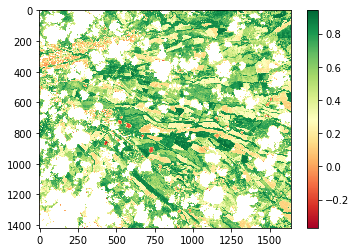

In [63]:
from matplotlib import pyplot
from rasterio.plot import show_hist

ndvi = sentinel_optical.getMaskedBand('NDVI', index=imindex)
infor = sentinel_optical.getTags('NDVI', index=imindex)

print('{} at {}'.format(infor['band_name'], infor['image_date']))
pyplot.imshow(ndvi, cmap='RdYlGn')
pyplot.colorbar()
pyplot.show()

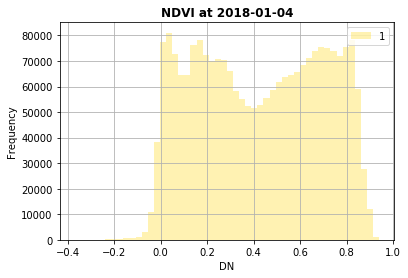

In [7]:
from rasterio.plot import show_hist

show_hist(ndvi, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled',
          title='{} at {}'.format(infor['band_name'], infor['image_date']))

In [9]:
## for mosaicing, a possible approach is gdalbuildvrt

# xarray

In [ ]:
## Check chunks meaning
#chunks = {'x': 5490, 'y': 5490, 'band': 1}
#da = xr.concat([xr.open_rasterio(f, chunks=chunks) for f in filenames], dim=time)

In [6]:
import pandas as pd
import xarray as xr

def buildXArray(prod, band):
    time = xr.Variable('time', pd.DatetimeIndex([pd.Timestamp(f) for f in prod.getTempData(band)]))
    arlist = [xr.open_rasterio(f) for f in prod.getOrigBandsLoc(band)]
    da = xr.concat(arlist, dim=time)
    return da

In [39]:
test = xr.open_rasterio(optical.getStackLoc('B2'))
test

<xarray.DataArray (band: 18, y: 1418, x: 1638)>
[41808312 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
  * y        (y) float64 4.939e+05 4.939e+05 4.939e+05 4.939e+05 4.939e+05 ...
  * x        (x) float64 4.793e+05 4.793e+05 4.793e+05 4.793e+05 4.793e+05 ...
Attributes:
    crs:                       +init=epsg:32618
    header_offset:             0
    description:               /home/azalazar/data/pre/stacks/B2.tif
    data_type:                 12
    nodatavals:                (nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
    file_type:                 ENVI Standard
    res:                       (10.0, 10.0)
    lines:                     1418
    transform:                 (479300.0, 10.0, -0.0, 493930.0, -0.0, -10.0)
    byte_order:                0
    coordinate_system_string:  PROJCS["WGS_1984_UTM_Zone_18N",GEOGCS["GCS_WGS...
    interleave:                bsq
    is_tiled:                  0
    samples: 

In [7]:
bands_of_interest = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'quality_cloud_confidence',
                         'quality_scene_classification']
std_names = ['blue','green','red','vrededg1','vrededg2','vrededg3','nir','narrownir','swir1','swir2',
                 'CloudQA1','CloudQA2']

#prod = optical
#band = 'B11'
#da = buildXArray(prod, band)

In [60]:
xarrays = []

for id, band in enumerate(bands_of_interest):
    x = buildXArray(optical, band).isel(band=0)
    #x.name = std_names[id]
    xarrays.append(x)

In [66]:
## To-do define type of dtype needed

band = xr.Variable('band', pd.Index(std_names))

#da = xr.concat(xarrays, bands)
#time = xr.Variable('time', pd.DatetimeIndex([pd.Timestamp(f) for f in optical.getTempData(band)]))
#xarrays[0].isel(band=0)
#da

band


<xarray.Variable (band: 12)>
array(['blue', 'green', 'red', 'vrededg1', 'vrededg2', 'vrededg3', 'nir',
       'narrownir', 'swir1', 'swir2', 'CloudQA1', 'CloudQA2'], dtype=object)

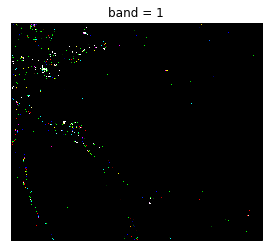

In [43]:
#da
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import datetime as dt

crs = ccrs.UTM('18N')
ax = plt.subplot(projection=crs)

da.isel(band=0, time=slice(1, 4)).plot.imshow(ax=ax, rgb='time', transform=crs)
plt.show()


In [10]:
radar.getTempData('VV')

[datetime.date(2018, 1, 16),
 datetime.date(2018, 3, 17),
 datetime.date(2018, 3, 29),
 datetime.date(2018, 1, 28),
 datetime.date(2018, 3, 5),
 datetime.date(2018, 2, 9),
 datetime.date(2018, 2, 21),
 datetime.date(2018, 1, 4)]

# da.isel(band=0, time=slice(1, 4))

In [20]:
ds

<xarray.Dataset>
Dimensions:  (band: 1, time: 8, x: 1638, y: 1418)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.939e+05 4.939e+05 4.939e+05 4.939e+05 4.939e+05 ...
  * x        (x) float64 4.793e+05 4.793e+05 4.793e+05 4.793e+05 4.793e+05 ...
  * time     (time) datetime64[ns] 2018-01-16 2018-03-17 2018-03-29 ...
Data variables:
    ibague   (time, band, y, x) float32 0.0 -13.410422 -13.508159 -14.243623 ...

In [12]:
dirlist = os.listdir("D:/eo_data/Ibague/data")
prdlist = filter(re.compile(r'^S2.....L2A').search, dirlist)
list(prdlist)

['S2A_MSIL2A_20171210T152631_N0206_R025_T18NVK_20171210T170838.SAFE']

## Read S-2 example

In [16]:
sentinel2_dir = "D:/eo_data/Ibague/data/"

s2_ = eoTempStack(sentinel2_dir, 'D:/eo_data/Ibague/data/', 'S2')

S2 empty object initialized from D:/eo_data/Ibague/data/


In [11]:
s2_cloud_jp2 = "D:/eo_data/Ibague/data/S2A_MSIL2A_20171210T152631_N0206_R025_T18NVK_20171210T170838.SAFE/GRANULE/L2A_T18NVK_A012892_20171210T152634/QI_DATA/L2A_T18NVK_20171210T152631_CLD_60m.jp2"

#jp2s = ["/tmp/B01.jp2", "/tmp/B09.jp2", "/tmp/B10.jp2"]
arrs = []

with rasterio.open(s2_cloud_jp2) as f:
    arrs.append(f.read(1))

data = np.array(arrs, dtype=arrs[0].dtype)
data.shape


(1L, 1830L, 1830L)

In [12]:
data.dtype

dtype('uint8')

In [13]:
#### gdal reprojection

from osgeo import gdal, gdalconst

inputfile = #Path to input file
input = gdal.Open(inputfile, gdalconst.GA_ReadOnly)
inputProj = input.GetProjection()
inputTrans = input.GetGeoTransform()

referencefile = #Path to reference file
reference = gdal.Open(referencefile, gdalconst.GAReadOnly)
referenceProj = reference.GetProjection()
referenceTrans = reference.GetGeoTransform()
bandreference = reference.GetRasterBand(1)    
x = reference.RasterXSize 
y = reference.RasterYSize


outputfile = #Path to output file
driver= gdal.GetDriverByName('GTiff')
output = driver.Create(outputfile,x,y,1,bandreference.DataType)
output.SetGeoTransform(referenceTrans)
output.SetProjection(referenceProj)

gdal.ReprojectImage(input,output,inputProj,referenceProj,gdalconst.GRA_Bilinear)

del output


In [14]:
#np.sum(bad_pixels)

#data

In [8]:
cloud_pixels_mask = data[0] > 9
cloud_cover = 1 - float(np.sum(cloud_pixels_mask)) / float(cloud_pixels_mask.size)

In [9]:
print cloud_cover

0.400828331691


In [102]:
from pprint import pprint
import rasterio
import numpy as np

path = radar_vv.stack_location
with rasterio.open(path) as src:
    array = src.read()

stats = []
i = 0
for band in array:
    ## First band has an error, is an empty band. From pre-processing in SNAP
    if i>0:
        stats.append({
            'min': band.min(),
            'mean': band.mean(),
            'median': np.median(band),
            'max': band.max()})
    i = i + 1

pprint(stats)

[{'max': 24.210934, 'mean': -8.817488, 'median': -8.756077, 'min': -24.761158},
 {'max': 23.672045, 'mean': -9.930789, 'median': -9.939377, 'min': -24.93194},
 {'max': 27.089819,
  'mean': -10.362202,
  'median': -10.394039,
  'min': -24.494234},
 {'max': 25.344566,
  'mean': -10.439367,
  'median': -10.537282,
  'min': -25.614614},
 {'max': 26.775578,
  'mean': -10.894947,
  'median': -11.015265,
  'min': -24.782732},
 {'max': 26.058949, 'mean': -9.558783, 'median': -9.597055, 'min': -24.783323},
 {'max': 26.774279, 'mean': -9.653883, 'median': -9.638872, 'min': -25.472023},
 {'max': 24.02989,
  'mean': -10.7197275,
  'median': -10.861368,
  'min': -25.61646},
 {'max': 24.58976, 'mean': -10.540494, 'median': -10.684661, 'min': -26.08511},
 {'max': 27.294153, 'mean': -9.116091, 'median': -9.133263, 'min': -24.8971},
 {'max': 24.374712, 'mean': -9.44039, 'median': -9.38195, 'min': -26.146618},
 {'max': 26.366924, 'mean': -9.546412, 'median': -9.493198, 'min': -25.246605},
 {'max': 23.46

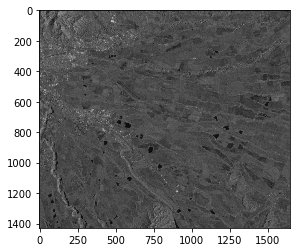

In [105]:
from rasterio.plot import show_hist
from matplotlib import pyplot

with rasterio.open(radar_vv.stack_location, 'r') as src:
    
    ## Histogram of values in a band
    
    #show_hist(src.read(5), bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")
    
    ## 2-D plot of a band in raster
    pyplot.imshow(src.read(5), cmap='gist_gray')
    pyplot.show()

In [109]:
## Read raster bands directly to Numpy arrays.
with rasterio.open(radar_vv.stack_location) as src:
    r = src.read(2)

# Combine arrays in place. Expecting that the sum will
# temporarily exceed the 8-bit integer range, initialize it as
# a 64-bit float (the numpy default) array. Adding other
# arrays to it in-place converts those arrays "up" and
# preserves the type of the total array.
total = np.zeros(r.shape)
total = r
#for band in r, g, b:
#    total += band
#total /= 3

print(total)
print(total.mean())

[[-14.442285  -14.385927  -13.71005   ... -12.045914  -10.946045
   -9.73858  ]
 [-14.436144  -12.844044  -12.306133  ...  -9.964807   -8.826512
   -7.950416 ]
 [-13.300525  -11.922127  -10.508951  ...  -8.596113   -7.516251
   -6.773493 ]
 ...
 [ -8.759519   -8.851126   -8.346581  ...  -9.826294  -11.018783
  -11.769825 ]
 [ -8.965732   -9.055018   -8.149572  ...  -9.940113  -11.063294
  -11.890546 ]
 [ -8.544774   -8.4334135  -8.427343  ... -10.141455  -10.724653
  -10.985925 ]]
-8.817488


In [110]:
with rasterio.open(radar_vv.stack_location) as src:
    print(src.width, src.height)
    print(src.crs)
    print(src.transform)
    print(src.count)
    print(src.indexes)

(1643, 1428)
CRS({'init': u'epsg:4326'})
[-75.1865348950781, 8.98315284119523e-05, -0.0, 4.4686296672161, -0.0, -8.98315284119523e-05]
21
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21)


C:\Anaconda2\envs\spatial-analysis\lib\site-packages\IPython\core\interactiveshell.py:2882: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1282, 938)
CRS({'init': u'epsg:32618'})
[471315.0, 30.0, 0.0, 500055.0, 0.0, -30.0]
8
(1, 2, 3, 4, 5, 6, 7, 8)


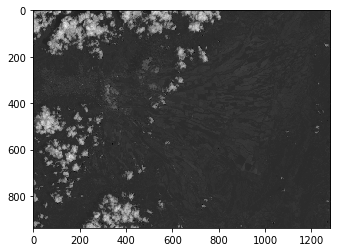

In [119]:
s1_loc = 'D:/eo_data/Ibague/LC08/pre/Ibague/LC08_L1TP_008057_20180301_20180308_01_T1.tif'

band_names = ["sr_band2", "sr_band3", "sr_band4", "sr_band5", "sr_band6", "sr_band7", "pixel_qa", "sr_aerosol"]

with rasterio.open(s1_loc) as src:
    
    print(src.width, src.height)
    print(src.crs)
    print(src.transform)
    print(src.count)
    print(src.indexes)
    i = 0
    while i > 8:
        print(src.tags())
    
    pyplot.imshow(src.read(1), cmap='gist_gray')
    pyplot.show()